# Introduction

Dynamic Models

- Clients: credit history starting before -2*m and ending at 0
- Features: concat static and dynamic information
- Dynamic Features: status count in previous months `(-2*m, -m)`
- Label: default in the most recent m months `(-m+1, 0)`
    - label 1: Choose IDs that overdue more than 30 days
    - label 0: Others

In [1]:
import collections
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, compose, model_selection
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import API

In [3]:
s_features=API.get_features()
d_features, d_labels=API.get_dynamic_data(m=3)
d_features.shape, d_labels.shape

data shape (438557, 17)
data shape after removing duplicates and setting ID (438463, 16)
data shape after removing outliers and adding indicators (438437, 17)


((39231, 8), (32804,))

In [4]:
ID=s_features.index.intersection(d_features.index.intersection(d_labels.index))
len(ID)

20155

In [5]:
X=pd.concat([s_features.loc[ID], d_features.loc[ID]], axis=1)
Y=d_labels.loc[ID]
X.shape, Y.shape

((20155, 25), (20155,))

In [6]:
X.dtypes

CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED          float64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
FLAG_EMPLOYED           object
0                        int64
1                        int64
2                        int64
3                        int64
4                        int64
5                        int64
C                        int64
X                        int64
dtype: object

In [7]:
features_categorical = X.columns[X.dtypes==object]
features_numerical = X.columns.difference(features_categorical)
features_transformer = compose.ColumnTransformer([
    ('dummy', preprocessing.OneHotEncoder(drop='first'), features_categorical),
    ('ss', preprocessing.StandardScaler(), features_numerical),
])
features_transformer

ColumnTransformer(transformers=[('dummy', OneHotEncoder(drop='first'),
                                 Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'FLAG_EMPLOYED'],
      dtype='object')),
                                ('ss', StandardScaler(),
                                 Index(['0', '1', '2', '3', '4', '5', 'AMT_INCOME_TOTAL', 'C', 'CNT_CHILDREN',
       'CNT_FAM_MEMBERS', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_EMAIL',
       'FLAG_PHONE', 'FLAG_WORK_PHONE', 'X'],
      dtype='object'))])

# Train Test Split

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=10)
X_train.shape, X_test.shape, y_train.sum(), y_test.sum()

((16124, 25), (4031, 25), 377, 90)

In [9]:
rng = np.random.default_rng(1234)
p_train=y_train.index[y_train==1] # id with positive labels
n_train=y_train.index[y_train==0] # id with negative labels
s_train=rng.choice(p_train, len(n_train)) # sampling with replacement from positive ids
I_sample=n_train.union(s_train)
X_sample=X_train.loc[I_sample]
y_sample=y_train.loc[I_sample]
y_sample.value_counts()

False    15747
True     15747
Name: label, dtype: int64

In [10]:
Results={}

# Decision Tree

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


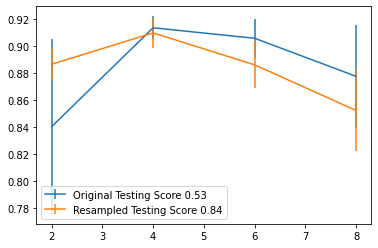

In [11]:
from sklearn.tree import DecisionTreeClassifier
def decision_tree_report(X_train, y_train, name):
    model = Pipeline([
        ('ft', features_transformer),
        ('model', DecisionTreeClassifier())
    ])
    parameters = {
        'model__max_depth': [2,4,6,8],
    }
    clf = model_selection.GridSearchCV(model, parameters, scoring='roc_auc', verbose=1)
    clf.fit(X_train, y_train)
    res=pd.DataFrame(clf.cv_results_).fillna('None')
    scr=metrics.roc_auc_score(y_test, clf.predict(X_test))
    plt.errorbar(res['param_model__max_depth'], res['mean_test_score'],
                 yerr=res['std_test_score'],
                 label=f'{name} Testing Score {scr:.2f}',
                )
    plt.legend()
    bst=res.loc[clf.best_index_]
    return dict(cv_mean=bst['mean_test_score'], cv_std=bst['std_test_score'], test_scr=scr)

Results['dt','original']=decision_tree_report(X_train, y_train, 'Original')
Results['dt','resampled']=decision_tree_report(X_sample, y_sample, 'Resampled')

## The model performs well for both train and test dataset with the dynamic features and resampled data

- both models choose `max_depth=4` and achive similar performance score
- however model trained with original data cannot perform well for testing
- model trained with resampled data perform well much better
- these observations are also much better than those from static models
- in other words, the dynamic features and predictive setting are more meaningful

# Gradient Boosting

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


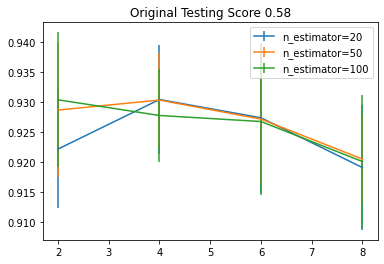

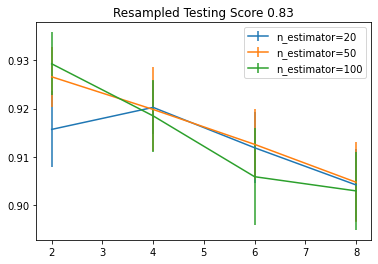

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
def gradient_boosting_report(X_train, y_train, name):
    model = Pipeline([
        ('ft', features_transformer),
        ('model', GradientBoostingClassifier())
    ])
    parameters = {
        'model__n_estimators': [20, 50, 100],
        'model__max_depth': [2, 4, 6, 8],
    }
    clf = model_selection.GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, verbose=1)
    clf.fit(X_train, y_train)
    res=pd.DataFrame(clf.cv_results_).fillna('None')
    scr=metrics.roc_auc_score(y_test, clf.predict(X_test))
    for n_estimator in parameters['model__n_estimators']:
        res_=res[res['param_model__n_estimators']==n_estimator]
        plt.errorbar(res_['param_model__max_depth'], res_['mean_test_score'], yerr=res_['std_test_score'],
                     label=f'n_estimator={n_estimator}',
                    )
        plt.legend()
        plt.title(f'{name} Testing Score {scr:.2f}')
    bst=res.loc[clf.best_index_]
    return dict(cv_mean=bst['mean_test_score'], cv_std=bst['std_test_score'], test_scr=scr)

plt.figure()
Results['gb','original']=gradient_boosting_report(X_train, y_train, 'Original')
plt.figure()
Results['gb','esampled']=gradient_boosting_report(X_sample, y_sample, 'Resampled')

## Summary

- GradientBoosting is more likely overfitting on the original data
- The model performs much better for testing with the resampled data

# Neurual Network

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


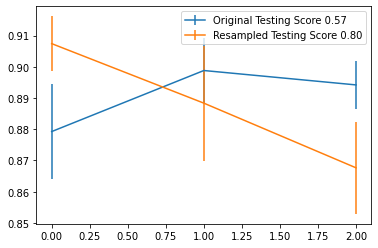

In [19]:
from sklearn.neural_network import MLPClassifier
def mlp_report(X_train, y_train, name):
    model = Pipeline([
        ('ft', features_transformer),
        ('model', MLPClassifier())
    ])
    parameters = {
        'model__hidden_layer_sizes': [[],[5],[10]],
    }
    clf = model_selection.GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, verbose=3)
    clf.fit(X_train, y_train)
    res=pd.DataFrame(clf.cv_results_).fillna('None')
    scr=metrics.roc_auc_score(y_test, clf.predict(X_test))
    plt.errorbar(range(len(parameters['model__hidden_layer_sizes'])), res['mean_test_score'],
                 yerr=res['std_test_score'],
                 label=f'{name} Testing Score {scr:.2f}',
                )
    plt.legend()
    bst=res.loc[clf.best_index_]
    return dict(cv_mean=bst['mean_test_score'], cv_std=bst['std_test_score'], test_scr=scr)

Results['nn','original']=mlp_report(X_train, y_train, 'Original')
Results['nn','resampled']=mlp_report(X_sample, y_sample, 'Resampled')

## Summary

- Not much better than alternatives given the limited data and model complexity
- Note that the the models on the left of the figure is just logistic regression without any hidden layers

# SVC

In [14]:
from sklearn.svm import SVC
def svc_report(X_train, y_train, name, n_jobs=None):
    model = Pipeline([
        ('ft', features_transformer),
        ('model', SVC())
    ])
    parameters = {
        'model__C': [1, 5, 10],
        'model__kernel': ['rbf', 'linear'],
    }
    clf = model_selection.GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=n_jobs, verbose=3)
    clf.fit(X_train, y_train)
    res=pd.DataFrame(clf.cv_results_).fillna('None')
    scr=metrics.roc_auc_score(y_test, clf.predict(X_test))
    for p in parameters['model__kernel']:
        res_=res[res['param_model__kernel']==p]
        plt.errorbar(res_['param_model__C'], res_['mean_test_score'], yerr=res_['std_test_score'],
                     label=p,
                    )
        plt.legend()
        plt.title(f'{name} Testing Score {scr:.2f}')
    bst=res.loc[clf.best_index_]
    return dict(cv_mean=bst['mean_test_score'], cv_std=bst['std_test_score'], test_scr=scr)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....model__C=1, model__kernel=rbf;, score=0.854 total time=   2.4s
[CV 2/5] END .....model__C=1, model__kernel=rbf;, score=0.857 total time=   2.5s
[CV 3/5] END .....model__C=1, model__kernel=rbf;, score=0.885 total time=   2.5s
[CV 4/5] END .....model__C=1, model__kernel=rbf;, score=0.869 total time=   2.5s
[CV 5/5] END .....model__C=1, model__kernel=rbf;, score=0.880 total time=   2.6s
[CV 1/5] END ..model__C=1, model__kernel=linear;, score=0.899 total time=   4.9s
[CV 2/5] END ..model__C=1, model__kernel=linear;, score=0.895 total time=   2.7s
[CV 3/5] END ..model__C=1, model__kernel=linear;, score=0.929 total time=   7.0s
[CV 4/5] END ..model__C=1, model__kernel=linear;, score=0.896 total time=   4.1s
[CV 5/5] END ..model__C=1, model__kernel=linear;, score=0.920 total time=   2.8s
[CV 1/5] END .....model__C=5, model__kernel=rbf;, score=0.851 total time=   2.4s
[CV 2/5] END .....model__C=5, model__kernel=rbf;,

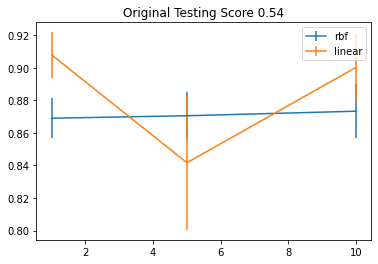

In [15]:
rng = np.random.default_rng(1234)
sub=rng.choice(len(X_train), 5000, False) # since svm is slow with large data ...
Results['svc','original']=svc_report(X_train, y_train, 'Original')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....model__C=1, model__kernel=rbf;, score=0.972 total time=   4.0s
[CV 2/5] END .....model__C=1, model__kernel=rbf;, score=0.967 total time=   3.8s
[CV 3/5] END .....model__C=1, model__kernel=rbf;, score=0.973 total time=   3.9s
[CV 4/5] END .....model__C=1, model__kernel=rbf;, score=0.973 total time=   3.9s
[CV 5/5] END .....model__C=1, model__kernel=rbf;, score=0.969 total time=   4.0s
[CV 1/5] END ..model__C=1, model__kernel=linear;, score=0.924 total time=   5.6s
[CV 2/5] END ..model__C=1, model__kernel=linear;, score=0.913 total time=   4.7s
[CV 3/5] END ..model__C=1, model__kernel=linear;, score=0.938 total time=   4.8s
[CV 4/5] END ..model__C=1, model__kernel=linear;, score=0.919 total time=   5.1s
[CV 5/5] END ..model__C=1, model__kernel=linear;, score=0.934 total time=   5.1s
[CV 1/5] END .....model__C=5, model__kernel=rbf;, score=0.981 total time=   3.3s
[CV 2/5] END .....model__C=5, model__kernel=rbf;,

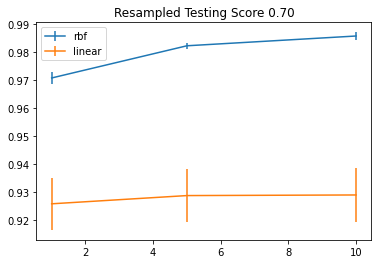

In [17]:
rng = np.random.default_rng(1234)
sub=rng.choice(len(X_sample), 10000, False)
Results['svc','resampled']=svc_report(X_sample.iloc[sub], y_sample.iloc[sub], 'Resampled')

## Summary

- rbf is better and stable for both cases
- and again, resampled data improves predicting new data
- but overall svc does not perform as well as alternatives given the limited data and computation power

# Conclusion

In [20]:
pd.DataFrame(Results)

dt                  gb                  nn            \
          original resampled  original  esampled  original resampled   
cv_mean   0.913570  0.909770  0.930398  0.929292  0.898815  0.907431   
cv_std    0.008577  0.011295  0.009103  0.006544  0.010489  0.008770   
test_scr  0.533080  0.844075  0.582445  0.834320  0.565525  0.804586   

               svc            
          original resampled  
cv_mean   0.907862  0.985792  
cv_std    0.013908  0.001348  
test_scr  0.543937  0.702604

- The dynamic features indeed improve performance of default predicting, especially when testing new data
- DecisionTree performs reasonablly well both with resampled and un-resampled data.
- This might be a good choice especially interpretable models are needed. The tree can be visualized to explain predictions.
- More dicusssions and comparisons on other models can be done similarly based on their corresponding mean and standard deviaion scores based on cross validation.